In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from finetune_helper_function import train_model, set_parameter_requires_grad, initialize_model

data_dir = "./data/hymenoptera_data"
model_name = "alexnet"
num_classes = 2
batch_size = 8
num_epochs = 15
feature_extract = True


model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_ft = model_ft.to(device)


params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [8]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


NameError: name 'device' is not defined

Epoch 0/14
----------
train Loss: 0.6938 Acc: 0.4426
val Loss: 0.6927 Acc: 0.5425

Epoch 1/14
----------
train Loss: 0.6938 Acc: 0.4631
val Loss: 0.6934 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6932 Acc: 0.4836
val Loss: 0.6923 Acc: 0.5425

Epoch 3/14
----------
train Loss: 0.6928 Acc: 0.5246
val Loss: 0.6926 Acc: 0.5882

Epoch 4/14
----------
train Loss: 0.6934 Acc: 0.4713
val Loss: 0.6931 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6936 Acc: 0.4795
val Loss: 0.6919 Acc: 0.5882

Epoch 6/14
----------
train Loss: 0.6930 Acc: 0.5041
val Loss: 0.6921 Acc: 0.6732

Epoch 7/14
----------
train Loss: 0.6926 Acc: 0.5246
val Loss: 0.6913 Acc: 0.6340

Epoch 8/14
----------
train Loss: 0.6921 Acc: 0.5861
val Loss: 0.6917 Acc: 0.6209

Epoch 9/14
----------
train Loss: 0.6919 Acc: 0.6230
val Loss: 0.6912 Acc: 0.6601

Epoch 10/14
----------
train Loss: 0.6919 Acc: 0.5246
val Loss: 0.6900 Acc: 0.6471

Epoch 11/14
----------
train Loss: 0.6917 Acc: 0.5451
val Loss: 0.6901 Acc: 0.6144

Ep

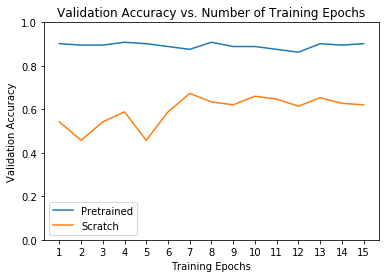

In [3]:

scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))


ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()